# VGGNet with tf-slim

## Highly inspired (and copy-pasted) from the [slim-walkthrough notebook](https://github.com/tensorflow/models/blob/master/slim/slim_walkthrough.ipynb)

### The script is tested on Ubuntu, you might encounter some problems on other platforms.

Prerequisites:
- **Python 2.7**, otherwise you'll run into problems
- **TensorFlow r1.1**: before this release, the pre-implemented nets were not included in the TF-Slim-package
- Clone the tensorflow-models repo (see the following commands)

Navigate to the models directory to gain access to the dataset helper methods to handle the **flowers** dataset.

The **whole tensorflow-models repository is about 154 MB in size!**
I also don't want to put the source code from the repo in here, because the repo would blow up.

Make sure that you cloned the repo. On Ubuntu you can execute the following cells (if git clone by SSH is configured).

In [1]:
cd ..

/home/niklas/ML-KA/tensorflow/team-tensorflow/sprint3_tf_models/src


In [2]:
%%bash
git clone git@github.com:tensorflow/models.git tensorflow_models

fatal: destination path 'tensorflow_models' already exists and is not an empty directory.


Verify that we are in the parent folder.

In [3]:
%%bash
ls -a # check for the location

.
..
alexnet
.gitignore
.idea
mnist
tensorflow_models
vggnet


In [4]:
cd tensorflow_models/slim

/home/niklas/ML-KA/tensorflow/team-tensorflow/sprint3_tf_models/src/tensorflow_models/slim


In [5]:
ll

total 136
-rw-rw-r-- 1 niklas  7172 Mai 31 16:50 BUILD
drwxrwxr-x 2 niklas  4096 Jun  1 17:56 datasets/
drwxrwxr-x 2 niklas  4096 Mai 31 16:50 deployment/
-rw-rw-r-- 1 niklas  2306 Mai 31 16:50 download_and_convert_data.py
-rw-rw-r-- 1 niklas  6666 Mai 31 16:50 eval_image_classifier.py
-rw-rw-r-- 1 niklas     1 Mai 31 16:50 __init__.py
-rw-rw-r-- 1 niklas   121 Mai 31 16:58 __init__.pyc
drwxrwxr-x 2 niklas  4096 Mai 31 16:50 nets/
drwxrwxr-x 2 niklas  4096 Mai 31 20:20 preprocessing/
-rw-rw-r-- 1 niklas 17487 Mai 31 16:50 README.md
drwxrwxr-x 2 niklas  4096 Mai 31 16:50 scripts/
-rw-rw-r-- 1 niklas 45649 Mai 31 16:50 slim_walkthrough.ipynb
-rwxrwxr-x 1 niklas 20042 Mai 31 16:50 train_image_classifier.py*
-rw-rw-r-- 1 niklas     0 Mai 31 16:50 WORKSPACE


In [6]:
import tensorflow as tf
import datasets, preprocessing
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

/home/niklas/anaconda3/envs/py27/lib/python2.7/site-packages/pandas/io/excel.py:626: UserWarning: Installed openpyxl is not supported at this time. Use >=1.6.1 and <2.0.0.
  .format(openpyxl_compat.start_ver, openpyxl_compat.stop_ver))


Specify the target directory for the data and download it. Make sure not to start a new download of the data every time the notebook is executed.

In [7]:
flowers_data_dir = '/media/niklas/lin-win-hdd/nn_datasets/image/flowers'

In [9]:
from datasets import download_and_convert_flowers
download_and_convert_flowers.run(flowers_data_dir)

Dataset files already exist. Exiting without re-creating them.


## Display the data

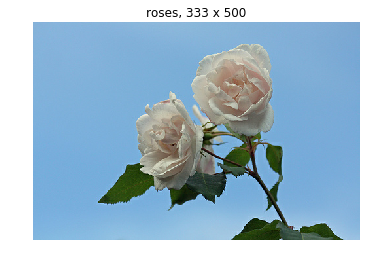

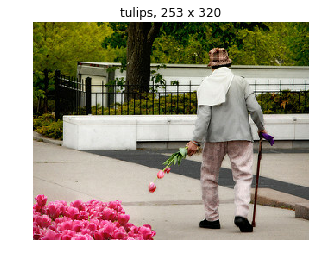

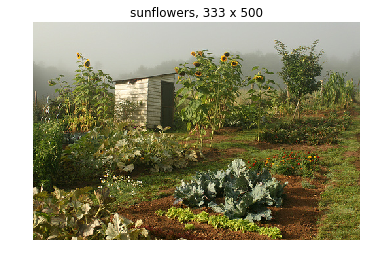

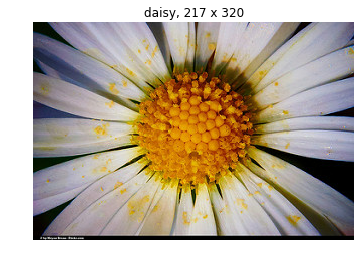

In [10]:
from datasets import flowers
# taken from https://github.com/tensorflow/models/blob/master/slim/slim_walkthrough.ipynb with slight modifications
slim = tf.contrib.slim

with tf.Graph().as_default(): 
    dataset = flowers.get_split('train', flowers_data_dir)
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32, common_queue_min=1)
    image, label = data_provider.get(['image', 'label'])
    
    with tf.Session() as sess:    
        with slim.queues.QueueRunners(sess):
            for i in xrange(4): 
                # creates a generator, "yield"
                np_image, np_label = sess.run([image, label])
                height, width, _ = np_image.shape
                class_name = name = dataset.labels_to_names[np_label]

                plt.figure()
                plt.imshow(np_image)
                plt.title('%s, %d x %d' % (name, height, width))
                plt.axis('off')
                plt.show()

Images have different sizes and are very heterogeneous

In [11]:
dataset.num_samples

3320

## A function to load batches from the dataset

In [12]:
from preprocessing import inception_preprocessing
import tensorflow as tf

slim = tf.contrib.slim


def load_batch(dataset, batch_size=32, height=299, width=299, is_training=False):
    """Loads a single batch of data.
    
    Args:
      dataset: The dataset to load.
      batch_size: The number of images in the batch.
      height: The size of each image after preprocessing.
      width: The size of each image after preprocessing.
      is_training: Whether or not we're currently training or evaluating.
    
    Returns:
      images: A Tensor of size [batch_size, height, width, 3], image samples that have been preprocessed.
      images_raw: A Tensor of size [batch_size, height, width, 3], image samples that can be used for visualization.
      labels: A Tensor of size [batch_size], whose values range between 0 and dataset.num_classes.
    """
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=64,
        common_queue_min=8)
    image_raw, label = data_provider.get(['image', 'label'])
    
    # Preprocess image for usage by Inception.
    image = inception_preprocessing.preprocess_image(image_raw, height, width, is_training=is_training)
    
    # Preprocess the image for display purposes.
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)

    # Batch it up.
    images, images_raw, labels = tf.train.batch(
          [image, image_raw, label],
          batch_size=batch_size,
          num_threads=2,
          capacity=2 * batch_size)
    
    return images, images_raw, labels


In [14]:
from tensorflow.contrib.slim.nets import vgg

## Training the Net

In [ ]:
from datasets import flowers
from tensorflow.contrib.slim.nets import vgg
import numpy as np

# This might take a few minutes.
train_dir = '/home/niklas/ML-KA/tensorflow/team-tensorflow/sprint3_tf_models/src/vggnet/logs'
print('Will save model to %s' % train_dir)
batch_size = 32

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    tf.summary.scalar('batch_size', batch_size)
    
    dataset = flowers.get_split('train', flowers_data_dir)
    # adjust height and width to alexnet dimensions
    # images: preprocessed images
    # images_raw: raw images
    images, images_raw, labels = load_batch(dataset, batch_size=batch_size, height=224 ,width=224, is_training=True)
    tf.summary.image('raw', images_raw)
    tf.summary.image('preprocessed', images)
    # Create the model:
    # net returns the logit values, end_points returns the nodes / operations 
    # (ordered dict to retain the ordering, very clever!) 
    net, end_points = vgg.vgg_a(images, num_classes=dataset.num_classes, is_training=True)
 
    # make summaries of every operation in the node
    for layer_name, layer_op in end_points.items():
        tf.summary.histogram(layer_name, layer_op)
    
    # Specify the loss function (outside the model!)
    one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)
    slim.losses.softmax_cross_entropy(net, one_hot_labels)
    total_loss = slim.losses.get_total_loss()

    # Create some summaries to visualize the training process:
    tf.summary.scalar('losses/Total Loss', total_loss)
  
    # Specify the optimizer and create the train op:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0001)
    train_op = slim.learning.create_train_op(total_loss, optimizer)
    
    # Track accuracy and recall
    predictions = tf.argmax(net, 1)
    
    # Define the metrics:
    # Recall@5 would make no sense, because we have only 5 classes here
    names_to_values, names_to_updates = slim.metrics.aggregate_metric_map({
        'eval/Accuracy': slim.metrics.streaming_accuracy(predictions, labels),
        'eval/Recall@2': slim.metrics.streaming_recall_at_k(net, labels, 2),
    })
    for name, tensor in names_to_updates.items():
        tf.summary.scalar(name, tensor)

    # Run the training:
    final_loss = slim.learning.train(
        train_op,
        logdir=train_dir,
        number_of_steps=int(21*np.floor(dataset.num_samples / batch_size)), # For speed, we just do 1 epoch
        session_config=tf.ConfigProto(log_device_placement=True),
        save_summaries_secs=10
        )
  
    print('Finished training. Final batch loss %d' % final_loss)


Will save model to /home/niklas/ML-KA/tensorflow/team-tensorflow/sprint3_tf_models/src/vggnet/logs
Instructions for updating:
Use tf.losses.softmax_cross_entropy instead. Note that the order of the logits and labels arguments has been changed.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
Instructions for updating:
Use tf.losses.get_total_loss instead.
Instructions for updating:
Use tf.losses.get_losses instead.
Instructions for updating:
Use tf.losses.get_regularization_losses instead.
INFO:tensorflow:Summary name losses/Total Loss is illegal; using losses/Total_Loss instead.
Instructions for updating:
Please use `streaming_sparse_recall_at_k`, and reshape labels from [batch_size] to [batch_size, 1].
INFO:tensorflow:Summary name eval/Recall@2 is illegal; using eval/Recall_2 instead.
INFO:tensorflow:Restoring parameters from /home/niklas/ML-KA/tensorflow/team-tensorflow/sprint3_tf_models/src/vggnet/log

In [31]:
names_to_updates

{'eval/Accuracy': <tf.Tensor 'accuracy/update_op:0' shape=() dtype=float32>,
 'eval/Recall@5': <tf.Tensor 'recall_at_5/update_op:0' shape=() dtype=float32>}

## The import of alexnet provides an ordered dict of Tensors. These can be equipped with custom summaries - a neat solution imho

In [17]:
end_points

OrderedDict([('alexnet_v2/conv1',
              <tf.Tensor 'alexnet_v2/conv1/Relu:0' shape=(32, 54, 54, 64) dtype=float32>),
             ('alexnet_v2/pool1',
              <tf.Tensor 'alexnet_v2/pool1/MaxPool:0' shape=(32, 26, 26, 64) dtype=float32>),
             ('alexnet_v2/conv2',
              <tf.Tensor 'alexnet_v2/conv2/Relu:0' shape=(32, 26, 26, 192) dtype=float32>),
             ('alexnet_v2/pool2',
              <tf.Tensor 'alexnet_v2/pool2/MaxPool:0' shape=(32, 12, 12, 192) dtype=float32>),
             ('alexnet_v2/conv3',
              <tf.Tensor 'alexnet_v2/conv3/Relu:0' shape=(32, 12, 12, 384) dtype=float32>),
             ('alexnet_v2/conv4',
              <tf.Tensor 'alexnet_v2/conv4/Relu:0' shape=(32, 12, 12, 384) dtype=float32>),
             ('alexnet_v2/conv5',
              <tf.Tensor 'alexnet_v2/conv5/Relu:0' shape=(32, 12, 12, 256) dtype=float32>),
             ('alexnet_v2/pool5',
              <tf.Tensor 'alexnet_v2/pool5/MaxPool:0' shape=(32, 5, 5, 256) dtyp